/var/folders/lt/152ggfsd6dn70n9w3bmlkrqh0000gn/T/ipykernel_81394/2283018074.py:12: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download("SPY", start="2015-01-01", end="2025-01-01")
[*********************100%***********************]  1 of 1 completed


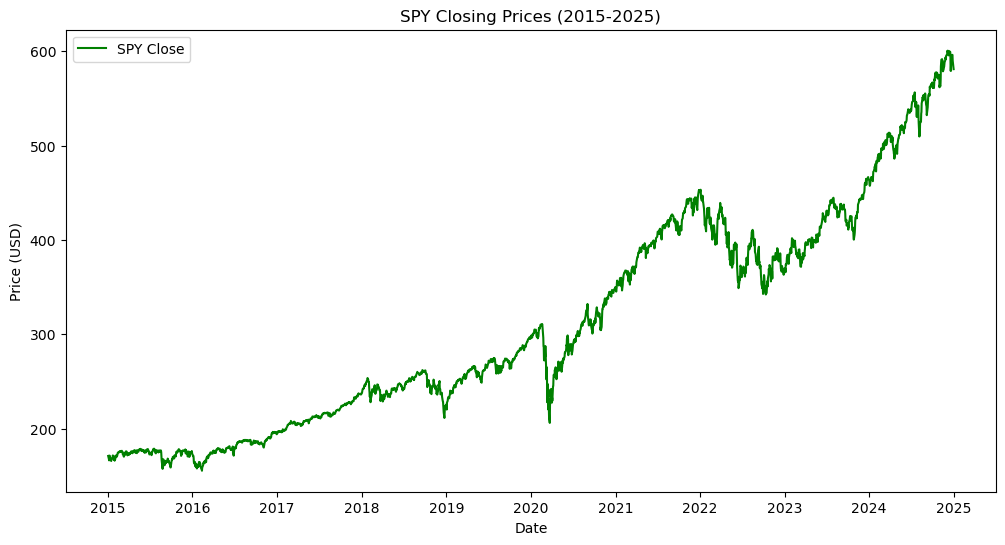

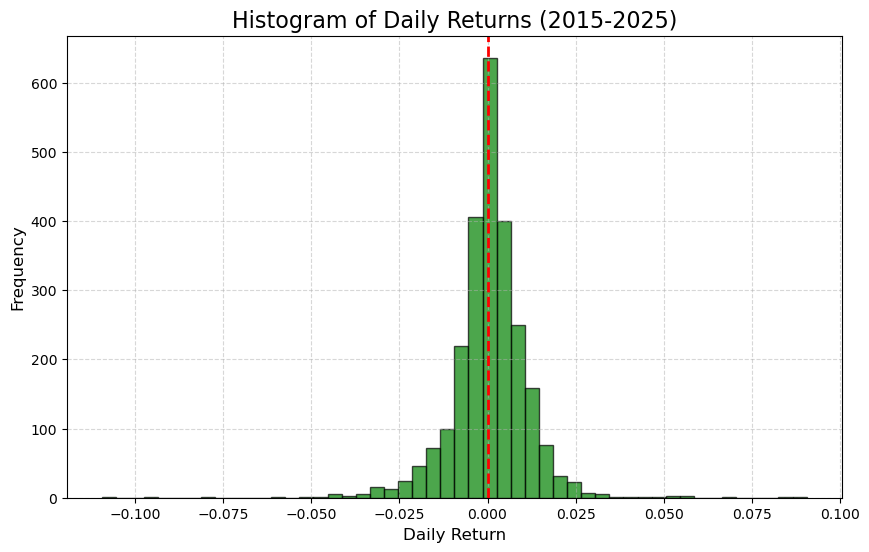

In [11]:
#importing libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
import seaborn as sns


#downloading SPY ETF since its a proxy for SP500

data = yf.download("SPY", start="2015-01-01", end="2025-01-01")

data.head()

#creating target variable for prediction model

#I want to predict whether the SP500 will close higher or lower tomorrow
# If tomorrows close is greater than todays I will set the target to 1 (price goes up).
# If tomorrows close is less than or equal to todays I set the target to 0 (price goes down or stays the same)

#so pretty much a binary classification problem 
data['Target'] = (data['Close'].shift(-1) > data['Close']).astype(int)

#dropping last row since no tomorrow :(
data = data.dropna()

data.head()

#making a little plot for the closing price
plt.figure(figsize=(12,6))
plt.plot(data['Close'], label='SPY Close', color = 'green')
plt.title('SPY Closing Prices (2015-2025)')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend()
plt.show()

#daily returns histograms

data['Return'] = data['Close'].pct_change()
returns = data['Return'].dropna()

plt.figure(figsize=(10,6))
plt.hist(data['Return'].dropna(), bins=50, color='green', edgecolor='black', alpha=0.7)
plt.axvline(0, color='red', linestyle='--', linewidth=2, label='Zero Return')
plt.title('Histogram of Daily Returns (2015-2025)', fontsize=16)
plt.xlabel('Daily Return', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

In [12]:
#Adding Simple Features
print(data.columns)

#this data frame has multi index columsn so gotta flatten it since its easier to use in ML
data.columns = ['_'.join(filter(None, col)).strip() for col in data.columns.values]

print(data.columns)


MultiIndex([( 'Close', 'SPY'),
            (  'High', 'SPY'),
            (   'Low', 'SPY'),
            (  'Open', 'SPY'),
            ('Volume', 'SPY'),
            ('Target',    ''),
            ('Return',    '')],
           names=['Price', 'Ticker'])
Index(['Close_SPY', 'High_SPY', 'Low_SPY', 'Open_SPY', 'Volume_SPY', 'Target',
       'Return'],
      dtype='object')


In [13]:
#moving averages
data['MA5'] = data['Close_SPY'].rolling(5).mean()
data['MA10'] = data['Close_SPY'].rolling(10).mean()

#rolling volatility (10 day std of returns)
data['Volatility'] = data['Return'].rolling(10).std()

#momentum (price difference over 10 days)
data['Momentum'] = data['Close_SPY'] - data['Close_SPY'].shift(10)


# drop rows with NaN in any feature
data = data.dropna(subset=['Return','MA5','MA10','Volatility','Momentum'])

# checking no more NaN values 
print("last 15 rows od dataset:")
print(data.tail(15))



last 15 rows od dataset:
             Close_SPY    High_SPY     Low_SPY    Open_SPY  Volume_SPY  \
Date                                                                     
2024-12-10  595.559448  598.523414  594.897513  598.098586    37234500   
2024-12-11  600.163513  601.121833  598.227034  598.503700    28677700   
2024-12-12  597.071106  599.867070  597.071106  599.294080    31543800   
2024-12-13  596.952576  599.837485  595.569368  599.116273    35904700   
2024-12-16  599.501526  600.479685  597.940547  598.721037    43695200   
2024-12-17  597.031555  597.900990  595.648407  596.932780    55773500   
2024-12-18  579.237915  599.126068  578.852585  596.725263   108248700   
2024-12-19  579.060059  585.877204  578.813061  584.256888    85919500   
2024-12-20  586.015137  590.575156  575.864033  576.716609   125716700   
2024-12-23  589.524414  590.129101  582.555449  585.757434    57635800   
2024-12-24  596.076965  596.116657  590.297589  590.882491    33160100   
2024-12-26  5

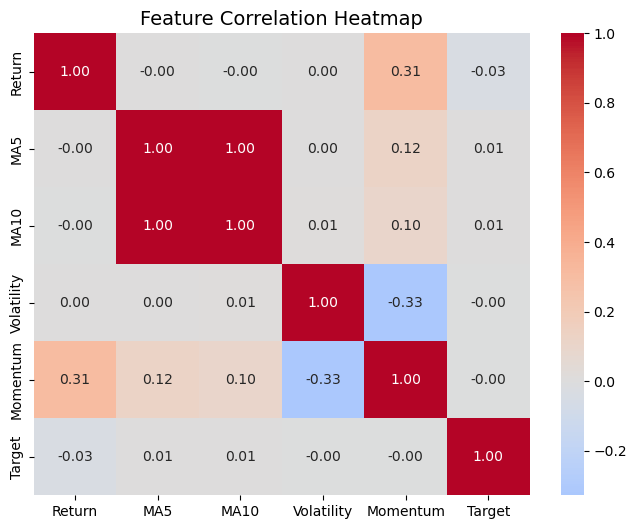

In [14]:
#correlation heatmap 

plt.figure(figsize=(8,6))
sns.heatmap(data[["Return","MA5","MA10","Volatility","Momentum","Target"]].corr(),
            annot=True, cmap="coolwarm", center=0, fmt=".2f")
plt.title("Feature Correlation Heatmap", fontsize=14)
plt.show()

MA5 and MA10 are pretty correlated (=1.00) which is expected because both are moving averages of the same series, but with different windows. Momemtum shows a moderate positive correlation with returns (=0.31) which suggests momentum could be a useful predictor as prices go trending upwards, returns tend to follow. Volatility is slightly negatively correlated with momentum (≈ –0.33). Higher short-term volatility often corresponds to weaker momentum. Target has very weak correlations with all features since its close to 0. 

In [15]:
#train/test split
from sklearn.model_selection import train_test_split
# Features (X) and Target (y)

#defining features and target
X = data[['Close_SPY', 'High_SPY', 'Low_SPY', 'Open_SPY', 'Volume_SPY', 'Return']]
y = data['Target']

# If there are NaNs, drop them so model training doesn’t fail
X = X.dropna()
y = y.loc[X.index]  #keep alignment


X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, shuffle=False
)


print(X_train.shape, X_test.shape)
print(y_train.shape, y_test.shape)



(2004, 6) (502, 6)
(2004,) (502,)


Traning Baseline Model

Training Logistic Regression

In [16]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

#train with logistic regression
model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)

#predictions
y_pred = model.predict(X_test)

#evaluating
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))


Accuracy: 0.5737051792828686
Confusion Matrix:
 [[  0 214]
 [  0 288]]
Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00       214
           1       0.57      1.00      0.73       288

    accuracy                           0.57       502
   macro avg       0.29      0.50      0.36       502
weighted avg       0.33      0.57      0.42       502



/opt/anaconda3/envs/finance/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/opt/anaconda3/envs/finance/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/opt/anaconda3/envs/finance/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", res

Logistic Regression didn’t perform well here. It mostly predicted “up days” because the SP 500 tends to drift upwards, giving it approx 57% accuracy. However, this isn’t much better than a naive strategy of always predicting “up,” so it doesn’t add meaningful predictive value. So, I decided to move on to more flexible models like Random Forest, which can capture non-linear relationships and interactions between features.

Random Forest

Random Forest Results
Accuracy: 0.5139442231075697
Confusion Matrix:
 [[ 97 117]
 [127 161]]
Classification Report:
               precision    recall  f1-score   support

           0       0.43      0.45      0.44       214
           1       0.58      0.56      0.57       288

    accuracy                           0.51       502
   macro avg       0.51      0.51      0.51       502
weighted avg       0.52      0.51      0.52       502



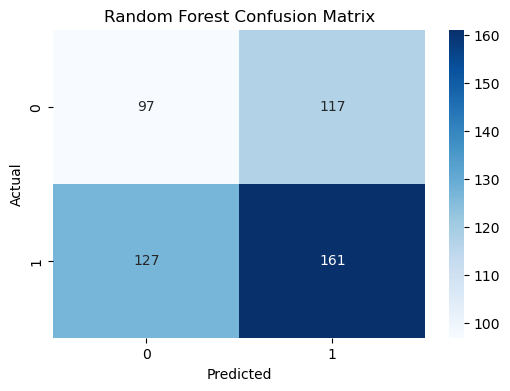

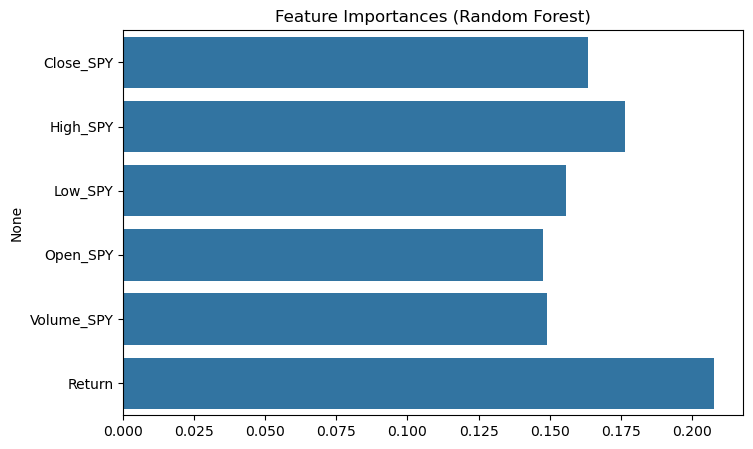

In [17]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

#train random forest
rf = RandomForestClassifier(
    n_estimators=100,# number of trees
    max_depth=5,# limit depth to avoid overfitting
    random_state=42
)
rf.fit(X_train, y_train)

#predictions 
y_pred_rf = rf.predict(X_test)

# evaluation
print("Random Forest Results")
print("Accuracy:", accuracy_score(y_test, y_pred_rf))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_rf))
print("Classification Report:\n", classification_report(y_test, y_pred_rf))

# Confusion matrix heatmap
plt.figure(figsize=(6,4))
sns.heatmap(confusion_matrix(y_test, y_pred_rf), annot=True, fmt="d", cmap="Blues")
plt.title("Random Forest Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# feature importance
importances = rf.feature_importances_
feature_names = X_train.columns

plt.figure(figsize=(8,5))
sns.barplot(x=importances, y=feature_names)
plt.title("Feature Importances (Random Forest)")
plt.show()



Interpretation of Random Forest: 
Accuracy is approx 51% so basically like flipping a coin which is better than nothing, but not by much. Class 0 (down/stay) where precision = 0.43, recall = 0.45 so model isn’t great at catching down days. Class 1 (up) where precision = 0.58, recall = 0.56 so its a bit better, but still weak.

Confusion Matrix tells us that the model predicts both 0s and 1s, unlike logistic regression (which only predicted 1s) so thats a beginning, but I think the key issue is that SP500 has a strong upward drift long term, which is true.  


The previous models (Logistic Regression and Random Forest) didn’t perform very well.  
Now I’ll engineer more technical indicators (momentum, volatility, RSI, etc.)  
to see if richer features can help capture short-term patterns in SPY movement.

In [19]:


# --- Make sure your data has a 'Close' column ---
# and a 'daily_return' or similar column showing percent or log returns

# Example (if you don't already have daily_return):
data['daily_return'] = data['Close_SPY'].pct_change()

# --- 1. Moving Averages ---
data['SMA_5'] = data['Close_SPY'].rolling(window=5).mean()
data['SMA_20'] = data['Close_SPY'].rolling(window=20).mean()

# --- 2. Bollinger Bands (volatility indicator) ---
data['BB_middle'] = data['SMA_20']
data['BB_upper'] = data['SMA_20'] + 2 * data['Close_SPY'].rolling(window=20).std()
data['BB_lower'] = data['SMA_20'] - 2 * data['Close_SPY'].rolling(window=20).std()

# --- 3. Relative Strength Index (RSI) ---
delta = data['Close_SPY'].diff()
gain = (delta.where(delta > 0, 0)).rolling(window=14).mean()
loss = (-delta.where(delta < 0, 0)).rolling(window=14).mean()
rs = gain / loss
data['RSI'] = 100 - (100 / (1 + rs))

# --- 4. Lagged Returns (momentum features) ---
for i in range(1, 6):
    data[f'return_lag_{i}'] = data['daily_return'].shift(i)

# --- 5. Drop NaNs created by rolling calculations ---
data = data.dropna()

# --- 6. Define features (X) and target (y) again ---
# Assuming your target is "1 if next day's return > 0 else 0"
data['target'] = (data['daily_return'].shift(-1) > 0).astype(int)
data = data.dropna()

feature_cols = [
    'daily_return', 'SMA_5', 'SMA_20', 'BB_upper', 'BB_lower',
    'RSI', 'return_lag_1', 'return_lag_2', 'return_lag_3',
    'return_lag_4', 'return_lag_5'
]

X = data[feature_cols]
y = data['target']

print("Feature engineering done!")
print("X shape:", X.shape)
print("y shape:", y.shape)


Feature engineering done!
X shape: (2487, 11)
y shape: (2487,)


/var/folders/lt/152ggfsd6dn70n9w3bmlkrqh0000gn/T/ipykernel_81394/3295018231.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['target'] = (data['daily_return'].shift(-1) > 0).astype(int)


LSTM


In [ ]:
from sklearn.preprocessing import StandardScaler
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam

# --- Scaling ---
scaler = StandardScaler()
scaled_features = scaler.fit_transform(data.drop(columns='target'))

# --- Sequence creation ---
X_lstm, y_lstm = [], []
time_steps = 10  # lookback period

for i in range(time_steps, len(scaled_features)):
    X_lstm.append(scaled_features[i-time_steps:i])
    y_lstm.append(data['target'].iloc[i])

X_lstm, y_lstm = np.array(X_lstm), np.array(y_lstm)

print("LSTM input shape:", X_lstm.shape)
print("Target shape:", y_lstm.shape)
# --- Train/test split (80/20) ---
split = int(0.8 * len(X_lstm))
X_train, X_test = X_lstm[:split], X_lstm[split:]
y_train, y_test = y_lstm[:split], y_lstm[split:]

# --- Model ---
model = Sequential([
    LSTM(64, return_sequences=False, input_shape=(time_steps, X_lstm.shape[2])),
    Dropout(0.2),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer=Adam(0.001), loss='binary_crossentropy', metrics=['accuracy'])

# --- Train ---
history = model.fit(X_train, y_train, epochs=15, batch_size=32, validation_data=(X_test, y_test), verbose=1)

# --- Evaluate ---
loss, accuracy = model.evaluate(X_test, y_test)
print(f"\nTest Accuracy: {accuracy:.3f}")


LSTM input shape: (2477, 10, 23)
Target shape: (2477,)
Epoch 1/15


/opt/anaconda3/envs/finance/lib/python3.13/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.5088 - loss: 0.6996 - val_accuracy: 0.5685 - val_loss: 0.6831
Epoch 2/15
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5386 - loss: 0.6910 - val_accuracy: 0.5706 - val_loss: 0.6845
Epoch 3/15
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5482 - loss: 0.6888 - val_accuracy: 0.5020 - val_loss: 0.6924
Epoch 4/15
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5416 - loss: 0.6885 - val_accuracy: 0.5121 - val_loss: 0.6933
Epoch 5/15
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5467 - loss: 0.6848 - val_accuracy: 0.4980 - val_loss: 0.7031
Epoch 6/15
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5528 - loss: 0.6865 - val_accuracy: 0.5585 - val_loss: 0.6876
Epoch 7/15
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5679 - loss: 0.6826 - val_accuracy: 0.5020 - val_loss: 0.6971
Epoch 8/15
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5724 - loss: 0.6792 - val_accuracy: 0.4758 - val_loss: 0.7014
Epo

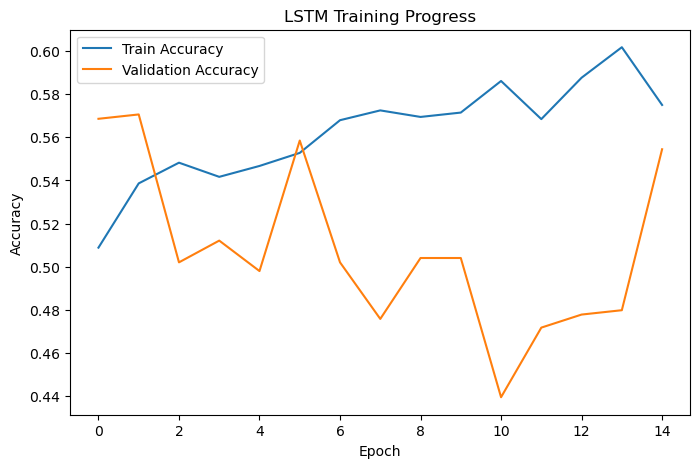

In [23]:
plt.figure(figsize=(8,5))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('LSTM Training Progress')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()